In [1]:
from insert_errors import (
    insert_maxim_error, float_to_maxim, maxim_to_float, insert_maxim_error_perbit
)
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
setpoint = 60
std_noise = .25
num_samples = 1_000_000
# SEU_thresh = .90 # 10% chance of a bit flipping
SEU_perbit = .99 # 1% chance of a bit flipping, for each bit

In [3]:
# UTLIS
def error_stats(data, expected, suppress=False):
    error = data - expected
    rmse = np.sqrt(np.sum((error)**2)/data.shape[0])
    stderr = np.std(error)
    if not suppress:
        print(f'RMSE from setpoint: {rmse}')
        print(f'Standard Deviation of error: {stderr}')
        print(f'Largest error: {np.max(error)} smallest error: {np.min(error)}')
    return rmse, stderr

In [4]:
'''
Experiment 0 a: Collect 1000000 temperatures from one TC with normal noise to
calculate RMSE for a non-upset datastream
'''
clean_data = np.full((num_samples,), setpoint, dtype=np.float32)
noise = np.random.normal(loc=0, scale=std_noise, size=clean_data.shape)
clean_data += noise

for i, d in enumerate(clean_data):
    # Quantize to maxim precision of .25
    clean_data[i] = maxim_to_float(float_to_maxim(d))

RMSE from setpoint: 0.2890966533877554
Standard Deviation of error: 0.26048964262008667
Largest error: 1.0 smallest error: -1.5


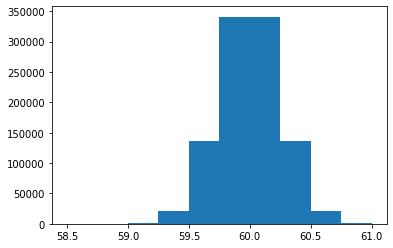

In [5]:
error_stats(clean_data, setpoint)
plt.hist(clean_data)
plt.show()

RMSE from setpoint: 0.15511221051729776
Standard Deviation of error: 0.09202304534687539
Largest error: 0.34375 smallest error: -0.53125


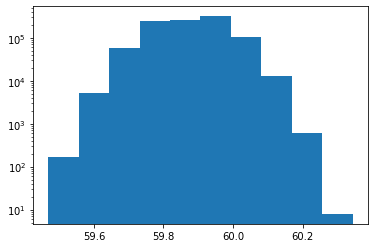

In [6]:
'''
Experiment 0 b: Collect 1000000 temperatures from 8 TCs averaged with normal
noise to calculate RMSE for a non-upset datastream
'''
tcs = np.array([(np.full((num_samples,), setpoint, dtype=np.float32) +
       np.random.normal(loc=0, scale=std_noise, size=(num_samples,)))
       for i in range(8)])

for tc in tcs:
    for i, d in enumerate(tc):
        # Quantize to maxim precision of .25
        tc[i] = maxim_to_float(float_to_maxim(d))

tc_avg = np.mean(tcs, axis=0)
error_stats(tc_avg, setpoint)
fig, ax = plt.subplots(1)
ax.hist(tc_avg)
ax.set_yscale('log')

In [7]:
''' 
Experiment 1: Collect 1000000 temperatures from one TC with normal noise
and apply SEUs to each reading with a probability P
'''

tc_data = np.full((num_samples,), setpoint, dtype=np.float32)
noise = np.random.normal(loc=0, scale=std_noise, size=tc_data.shape)
tc_data += noise

for i, d in enumerate(tc_data):
    # Quantize to maxim precision of .25
    tc_data[i] = maxim_to_float(float_to_maxim(d))
    

with_seu = np.zeros_like(tc_data)
for i in range(with_seu.shape[0]):
    with_seu[i] = insert_maxim_error_perbit(tc_data[i],
                                            upset_threshold=SEU_perbit)
    

RMSE from setpoint: 120.08883325272171
Standard Deviation of error: 118.79564666748047
Largest error: 1791.75 smallest error: -1655.5


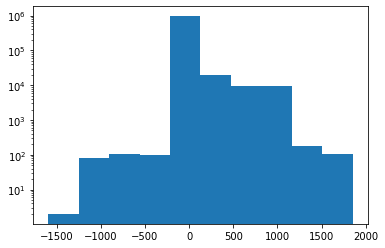

In [8]:
error_stats(with_seu, setpoint)
fig, ax = plt.subplots(1)
ax.hist(with_seu)
ax.set_yscale('log')

In [9]:
''' 
Experiment 2 a: Generate temperatures with SEUs for 8 TCs and do the 
average on them.
'''
tcs = np.array([(np.full((num_samples,), setpoint, dtype=np.float32) +
       np.random.normal(loc=0, scale=std_noise, size=tc_data.shape))
       for i in range(8)])

for tc in tcs:
    for i, d in enumerate(tc):
        # Quantize to maxim precision of .25
        tc[i] = maxim_to_float(float_to_maxim(d))

In [10]:
tcs_seu = np.array([np.zeros_like(tcs[0]) for i in range(len(tcs))])

for idx, tc in enumerate(tcs_seu):
    for i in range(tc.shape[0]):
        tc[i] = insert_maxim_error_perbit(tcs[idx][i],
                                          upset_threshold=SEU_perbit)

In [11]:
# Compute avg
tc_avg = np.mean(tcs_seu, axis=0)

RMSE from setpoint: 45.39497268929852
Standard Deviation of error: 41.87072488364983
Largest error: 448.53125 smallest error: -207.125


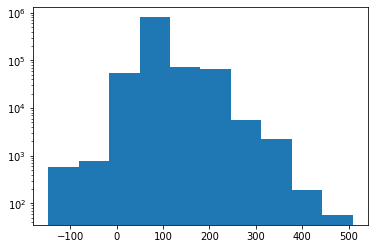

In [12]:
error_stats(tc_avg, setpoint)
fig, ax = plt.subplots(1)
ax.hist(tc_avg)
ax.set_yscale('log')

RMSE from setpoint: 1.4329100103133658
Standard Deviation of error: 1.429415819521758
Largest error: 319.75 smallest error: -60.125


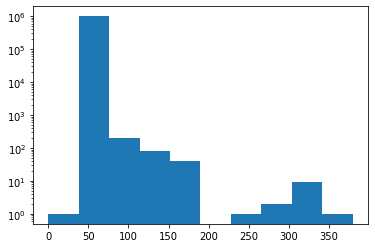

In [13]:
''' 
Experiment 2 b: Median on 8 TCs
'''
tc_medians = np.median(tcs_seu, axis=0)
error_stats(tc_medians, setpoint)
fig, ax = plt.subplots(1)
ax.hist(tc_medians)
ax.set_yscale('log')

In [14]:
# Plurality UTILS
from itertools import chain, combinations

def powerset(iterable, k):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(k, len(s)+1))

In [15]:
'''
Experiment 2 c: k-Plurality voting on 8 TCs
k=?
When no agreement, output median.
Use average of agreeing subset
'''

# For each set of measurements, determine biggest subset of agreeable values
# for i in range(tcs_seu.shape[1]):
def plurality(tcs_seu, num_pts, k, delta, suppress=False):
    defaults = np.median(tcs_seu, axis=0)
    voted_out = defaults.copy()

    for i in range(num_pts):
        ps = powerset(tcs_seu[:, i], k)
        best = tuple()
        for s in ps: # for each subset in powerset i.e. (60, 60.5, 71)
            all_within = True
            for meas in s:
                for other in s:
                    # If any measurement in this subset is not valid, break
                    if abs(meas - other) > delta:
                        all_within = False
                        break
                if not all_within:
                    break
            if not all_within:
                continue
            if all_within and len(s) > len(best):
                best = s
        if len(best) >= k:
            voted_avg = sum(best)/len(best)
            voted_out[i] = voted_avg
        else:
            if not suppress:
                print(f'i={i} using median {defaults[i]} for data {tcs_seu[:,i]}') 
    return voted_out

def plurality_fast(tcs_seu, num_pts, k, delta, suppress=False):
    defaults = np.nanmedian(tcs_seu, axis=0)
    voted_out = defaults.copy()
    
    num_not_agreed = 0
    
    for i in range(num_pts):
        msmts = tcs_seu[:, i]
        valid_msmts = msmts[~np.isnan(msmts)]
        ps = powerset(valid_msmts, k)
        best = tuple()
        for s in ps: # for each subset in powerset i.e. (60, 60.5, 71)
            if abs(max(s) - min(s)) > delta:
                continue
            if len(s) > len(best):
                best = s
        if len(best) >= k:
            voted_avg = sum(best)/len(best)
            voted_out[i] = voted_avg
        else:
            num_not_agreed += 1
            if not suppress:
                print(f'i={i} using median {defaults[i]} for data {tcs_seu[:,i]}') 
    print(f'{num_not_agreed} measurements did not agree for k={k} delta={delta}')
    return voted_out

In [16]:
plurality_fast

<function __main__.plurality_fast>

In [17]:
# With max min optimization
s = time.time()
plural_voted100fast = plurality_fast(tcs_seu, 100, 5, 1)
e = time.time()
print(e - s)

i=64 using median 60.625 for data [124.25 316.   188.    59.75  61.25  60.    59.75  59.75]
1 measurements did not agree for k=5 delta=1
0.4206998348236084


In [18]:
# With max min optimization
s = time.time()
plural_voted1000fast = plurality_fast(tcs_seu, 1000, 5, 1)
e = time.time()
print(e - s)

i=64 using median 60.625 for data [124.25 316.   188.    59.75  61.25  60.    59.75  59.75]
i=105 using median 92.0 for data [ 59.5  124.    58.5  188.   126.25  60.    59.75 315.75]
i=197 using median 60.0 for data [ 59.75  51.75  59.75 123.75 572.    27.5   63.75  60.25]
i=203 using median 60.5 for data [124.    60.25 571.5  316.    59.75  59.5   60.75  59.5 ]
i=310 using median 60.25 for data [124.25 188.    60.    60.5   60.    57.75 571.75  54.  ]
i=367 using median 60.0 for data [ 60.    56.5   62.   185.75  60.    56.25  59.75  60.  ]
i=436 using median 60.0 for data [ 60.25  59.    62.25  59.75  52.    60.   124.25  60.  ]
i=491 using median 59.75 for data [ 60.   -60.25  43.75  59.75  27.75  60.25  59.75 188.  ]
i=554 using median 60.375 for data [ 60.5   59.25 571.75  59.5   63.5  827.5   59.75  60.25]
i=572 using median 59.875 for data [ 60.5  123.75 -59.75 -59.75  59.5   59.75  60.    63.75]
i=587 using median 59.875 for data [ 60.    43.75 315.75 124.25  59.5   59.75  60. 

In [19]:
# With max min optimization
s = time.time()
plural_voted10_000fast = plurality_fast(tcs_seu, 10000, 5, 1, suppress=True)
e = time.time()
print(e - s)

97 measurements did not agree for k=5 delta=1
1.6505260467529297


In [20]:
# With max min optimization
s = time.time()
plural_voted100_000fast = plurality_fast(tcs_seu, 100000, 5, 1, suppress=True)
e = time.time()
print(e - s)

909 measurements did not agree for k=5 delta=1
10.89987301826477


In [21]:
# k=5, delta=1
s = time.time()
plural_voted1_000_000fast = plurality_fast(tcs_seu, 1000000, 5, 1, suppress=True)
e = time.time()
print(e - s)
error_stats(plural_voted1_000_000fast, setpoint)

9184 measurements did not agree for k=5 delta=1
105.9413013458252
RMSE from setpoint: 1.4309380342495281
Standard Deviation of error: 1.4271368454499849
Largest error: 319.75 smallest error: -60.125


(1.4309380342495281, 1.4271368454499849)

In [22]:
# k=5, delta=1
s = time.time()
plural_voted1_000_000fastnew = plurality_fast(tcs_seu, 1000000, 5, 1, suppress=True)
e = time.time()
print(e - s)
error_stats(plural_voted1_000_000fastnew, setpoint)

9184 measurements did not agree for k=5 delta=1
105.33676290512085
RMSE from setpoint: 1.4309380342495281
Standard Deviation of error: 1.4271368454499849
Largest error: 319.75 smallest error: -60.125


(1.4309380342495281, 1.4271368454499849)

In [23]:
error_stats(plural_voted1_000_000fast, setpoint)

RMSE from setpoint: 1.4309380342495281
Standard Deviation of error: 1.4271368454499849
Largest error: 319.75 smallest error: -60.125


(1.4309380342495281, 1.4271368454499849)

In [24]:
# k=5, delta=1
s = time.time()
plural_k5d1 = plurality_fast(tcs_seu, 1000000, 5, 1, suppress=True)
e = time.time()
print(e - s)
error_stats(plural_k5d1, setpoint)

9184 measurements did not agree for k=5 delta=1
104.71977949142456
RMSE from setpoint: 1.4309380342495281
Standard Deviation of error: 1.4271368454499849
Largest error: 319.75 smallest error: -60.125


(1.4309380342495281, 1.4271368454499849)

In [25]:
# k=4, delta=1
s = time.time()
plural_k4d1 = plurality_fast(tcs_seu, 1000000, 4, 1, suppress=True)
e = time.time()
print(e - s)
error_stats(plural_k4d1, setpoint)

883 measurements did not agree for k=4 delta=1
170.72027707099915
RMSE from setpoint: 0.8273537402905974
Standard Deviation of error: 0.8189674576819023
Largest error: 319.75 smallest error: -32.125


(0.8273537402905974, 0.8189674576819023)

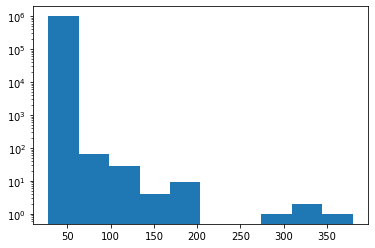

In [26]:
fig, ax = plt.subplots(1)
ax.hist(plural_k4d1)
ax.set_yscale('log')

In [27]:
# k=4, delta=2
s = time.time()
plural_k4d2 = plurality_fast(tcs_seu, 1000000, 4, 2, suppress=True)
e = time.time()
print(e - s)
error_stats(plural_k4d2, setpoint)

529 measurements did not agree for k=4 delta=2
173.4157359600067
RMSE from setpoint: 0.799938485786001
Standard Deviation of error: 0.7911587098942301
Largest error: 319.75 smallest error: -32.125


(0.799938485786001, 0.7911587098942301)

In [28]:
# k=3, delta=1
s = time.time()
plural_k3d1 = plurality_fast(tcs_seu, 1000000, 3, 1, suppress=True)
e = time.time()
print(e - s)
error_stats(plural_k3d1, setpoint)

41 measurements did not agree for k=3 delta=1
236.7517249584198
RMSE from setpoint: 1.4574482618484963
Standard Deviation of error: 1.4524888340909239
Largest error: 1024.0833333333333 smallest error: -120.08333333333334


(1.4574482618484963, 1.4524888340909239)

In [29]:
# k=2, delta=1
s = time.time()
plural_k2d1 = plurality_fast(tcs_seu, 1000000, 2, 1, suppress=True)
e = time.time()
print(e - s)
error_stats(plural_k2d1, setpoint)

0 measurements did not agree for k=2 delta=1
250.64359140396118
RMSE from setpoint: 2.0532520695144085
Standard Deviation of error: 2.049850687889958
Largest error: 1024.0833333333333 smallest error: -120.08333333333334


(2.0532520695144085, 2.049850687889958)

In [30]:
'''
Experiment 3 a: Input validation with 8 TC - Average valid values
'''
# Using tcs_seu array for data
low_bound = -200
up_bound = 200

invalid = (tcs_seu < low_bound) | (tcs_seu > up_bound)

valid = tcs_seu.copy()
valid[invalid] = np.NAN

valid_avg = np.nanmean(valid, axis=0)

RMSE from setpoint: 6.851835718145158
Standard Deviation of error: 6.851834264039705
Largest error: 63.54166666666667 smallest error: -73.65


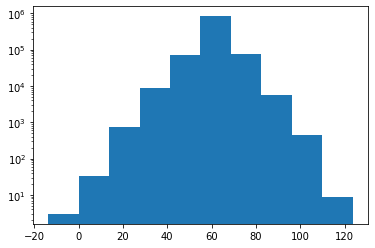

In [31]:
error_stats(valid_avg, setpoint)
fig, ax = plt.subplots(1)
ax.hist(valid_avg)
ax.set_yscale('log')

In [32]:
'''
Experiment 3 b: Input validation with 8 TC - Median of valid values
'''
# Using tcs_seu array for data
low_bound = -200
up_bound = 200

invalid = (tcs_seu < low_bound) | (tcs_seu > up_bound)

valid = tcs_seu.copy()
valid[invalid] = np.NAN

valid_med = np.nanmedian(valid, axis=0)

RMSE from setpoint: 0.25879928576504996
Standard Deviation of error: 0.2221452235883306
Largest error: 62.875 smallest error: -60.125


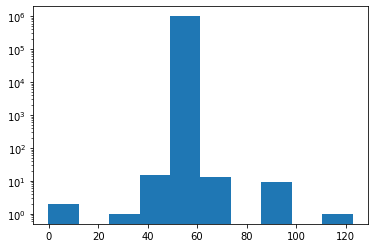

In [33]:
error_stats(valid_med, setpoint)
fig, ax = plt.subplots(1)
ax.hist(valid_med)
ax.set_yscale('log')

In [34]:
'''
Experiment 3 c: Input validation with 8 TC - Plurality vote on valid values
'''
# Using tcs_seu array for data
low_bound = -200
up_bound = 200

invalid = (tcs_seu < low_bound) | (tcs_seu > up_bound)

valid = tcs_seu.copy()
valid[invalid] = np.NAN

# k=4, delta=1
k=4
delta=1
plural_valid_k4d1 = plurality_fast(valid, valid.shape[1], k, delta, suppress=True)

883 measurements did not agree for k=4 delta=1


RMSE from setpoint: 0.2125654050324073
Standard Deviation of error: 0.17251683713594407
Largest error: 62.875 smallest error: -60.0


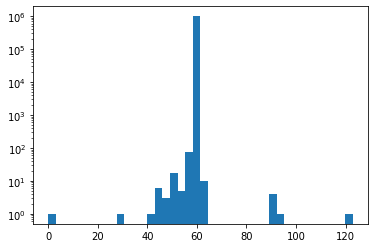

In [35]:
error_stats(plural_valid_k4d1, setpoint)
fig, ax = plt.subplots(1)
ax.hist(plural_valid_k4d1, bins=40)
ax.set_yscale('log')

In [36]:
# k=3, delta=1
k=3
delta=1
plural_valid_k3d1 = plurality_fast(valid, valid.shape[1], k, delta, suppress=True)

KeyboardInterrupt: 

In [ ]:
error_stats(plural_valid_k3d1, setpoint)
fig, ax = plt.subplots(1)
ax.hist(plural_valid_k3d1, bins=40)
ax.set_yscale('log')

In [ ]:
# k=2, delta=1
k=2
delta=1
plural_valid_k2d1 = plurality_fast(valid, valid.shape[1], k, delta, suppress=True)

In [ ]:
error_stats(plural_valid_k2d1, setpoint)
fig, ax = plt.subplots(1)
ax.hist(plural_valid_k2d1, bins=40)
ax.set_yscale('log')

In [ ]:
# k=3, delta=3
k=3
delta=3
plural_valid_k3d3 = plurality_fast(valid, valid.shape[1], k, delta, suppress=True)


In [ ]:
error_stats(plural_valid_k3d3, setpoint)
fig, ax = plt.subplots(1)
ax.hist(plural_valid_k3d3, bins=40)
ax.set_yscale('log')

In [37]:
'''
Generate lots of k-Plurality RMSE and STD data with input validation
'''
ks = np.arange(2,8+1)
deltas = np.linspace(.1, 3, 10)
rmses = np.zeros((len(ks), len(deltas)))
stds = np.zeros_like(rmses)
for i, k in enumerate(ks):
    for j, d in enumerate(deltas):
        v = plurality_fast(valid, valid.shape[1], k, d, suppress=True)
        rmse, std = error_stats(v, setpoint, suppress=True)
        rmses[i, j] = rmse
        stds[i, j] = std

2658 measurements did not agree for k=2 delta=0.1
27 measurements did not agree for k=2 delta=0.42222222222222217
1 measurements did not agree for k=2 delta=0.7444444444444444
0 measurements did not agree for k=2 delta=1.0666666666666667
0 measurements did not agree for k=2 delta=1.3888888888888888
0 measurements did not agree for k=2 delta=1.711111111111111
0 measurements did not agree for k=2 delta=2.033333333333333
0 measurements did not agree for k=2 delta=2.3555555555555556
0 measurements did not agree for k=2 delta=2.6777777777777776
0 measurements did not agree for k=2 delta=3.0
172951 measurements did not agree for k=3 delta=0.1
3591 measurements did not agree for k=3 delta=0.42222222222222217
323 measurements did not agree for k=3 delta=0.7444444444444444
43 measurements did not agree for k=3 delta=1.0666666666666667
35 measurements did not agree for k=3 delta=1.3888888888888888
31 measurements did not agree for k=3 delta=1.711111111111111
24 measurements did not agree for k=3

In [42]:
np.unravel_index(np.argmin(rmses), rmses.shape)

(2, 3)

In [43]:
ks[2]

4

In [45]:
rmses[:, 3]


array([0.46793921, 0.40899497, 0.21256541, 0.24139106, 0.2435809 ,
       0.24843401, 0.25510517])

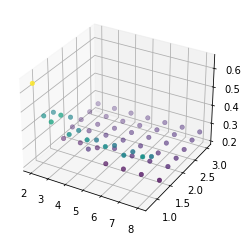

In [56]:
x = np.tile(ks, len(deltas[2:])).reshape((len(ks)*len(deltas[2:]),))
y = np.repeat(deltas[2:], len(ks))
z = np.reshape(rmses[:, 2:], (len(ks)*len(deltas[2:],)))
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5);

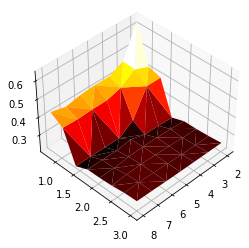

In [75]:
ax = plt.axes(projection='3d')
ax.plot_trisurf(x, y, z,
                cmap='hot', edgecolor='none');
ax.view_init(40, 45)

In [76]:
np.savetxt('rmses.saved', rmses)
np.savetxt('stds.saved', stds)